# Vision Transformer in pytorch

https://arxiv.org/pdf/2010.11929.pdf

In [1]:
from einops import rearrange
from einops.layers.torch import Rearrange
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torchsummary import summary

from utils import show_numpy_image, show_numpy_image_grid

In [13]:
D = 768                     # latent size
H, W, C = 384, 384, 3       # input image size
P = 16                      # patch size
N = int((H * W) / (P * P))  # number of patches
NUM_HEADS = 12              # number of heads for attention
MLP_SIZE = 3072             # encoder mlp hidden unit size
ENC_LAYERS = 12                 # transformer encoder number of layers

Test einops rearrange method to split input image to patches

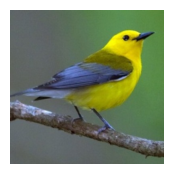

input shape: (384, 384, 3)
patches shape: (36, 64, 64, 3)


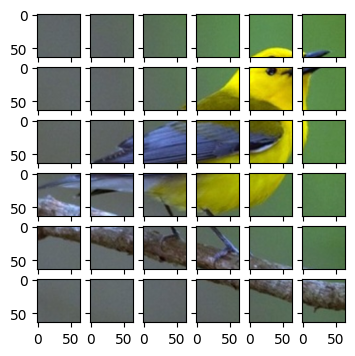

In [3]:
# einops rearrange method to split image into patches
img = np.asarray(Image.open('resources/bird.jpeg'))
show_numpy_image(img, fig_size=(2, 2))
print(f"input shape: {img.shape}")

patches = rearrange(img, '(h p1) (w p2) c -> (h w) p1 p2 c', p1=64, p2=64)
print(f"patches shape: {patches.shape}")

show_numpy_image_grid(patches, fig_size=(4, 4), rows=H//64, cols=W//64)

### Patch Embedding module

In [4]:
class PatchEmbedding(nn.Module):
    """Converts an image to patches and flattens them to D dimensions
    
    Input:
        Image : (B x C x H x W) where
        B = batch size
        H = image height
        W = image width
        C = image channels

    Output:
        Patch embedding: (B x (N + 1) x D) where 
        D = embedding dimension
        N = number of patches
    
    """
    def __init__(self, image_size, patch_size, projection_dim) -> None:
        super().__init__()
        self.image_size = image_size

        if (image_size[0] % patch_size[0] != 0 or image_size[1] % patch_size[1] != 0):
            raise ValueError("Patch size should be divisible by image size")

        self.patch_size = patch_size
        self.projection_dim = projection_dim
        self.num_patches = (image_size[0] // patch_size[0]) * (image_size[1] // patch_size[1])

        # convert to patches
        self.to_patches = Rearrange('b c (h ph) (w pw) -> b (h w) ph pw c', 
                                    ph=self.patch_size[0],
                                    pw=self.patch_size[1])

        # flatten patches -> (b, num_patches, patch_size * patch_size * 3)
        self.flatten_patches = nn.Flatten(2, 4)

        # linear layer -> (b, num_patches, D)
        self.projection = nn.Linear(self.patch_size[0] * self.patch_size[1] * 3, 
                                    self.projection_dim)

        self.class_embedding = nn.Parameter(torch.randn(1, 1, self.projection_dim))
        self.pos_embedding = nn.Parameter(torch.randn(1, self.num_patches + 1, self.projection_dim))

    def forward(self, input):
        out = self.flatten_patches(self.to_patches(input))
        b, n, d = out.shape

        out = self.projection(out)
        out = torch.cat((out, self.class_embedding.expand(b, -1, -1)), dim=1)
        out += self.pos_embedding

        return out

Test position embeddings layer

In [5]:
def test_patchembedding():
    input = torch.randn(32, C, H, W)
    print(f"Input shape: {input.shape}")

    patch_embedding = PatchEmbedding((H, W), (P, P), D)
    out = patch_embedding(input)
    print(out.shape)

test_patchembedding()

Input shape: torch.Size([32, 3, 384, 384])
torch.Size([32, 577, 768])


### Multi-head Self Attention module

In [6]:
class MultiHeadSelfAttention(nn.Module):
    """Multi-head SelfAttention module
    
    inputs:
        sequence: (B x (N + 1) x D) 
        
    outputs:
        sequence: (B x (N + 1) x D)
    
    """
    def __init__(self, input_dim, num_heads = 1, msa_dropout_prob=0.) -> None:
        super().__init__()

        self.input_dim = input_dim
        self.num_heads = num_heads

        if input_dim % num_heads != 0:
            raise ValueError("Input dimension should be divisible by number of heads")

        self.head_dim = input_dim // num_heads
        self.scale = self.head_dim ** -0.5

        self.kqv = nn.Linear(input_dim, input_dim * 3)
        self.attn_weights = nn.Softmax(dim = -1)
        self.msa = nn.Linear(input_dim, input_dim)
        self.msa_dropout = nn.Dropout(p = msa_dropout_prob)

    def forward(self, input):
        b, n, d = input.shape
        
        # op: (B x (num_patches + 1) x input_dim * 3)
        out = self.kqv(input)

        # op: tuple of q, k, v (B x (num_patches + 1) x input_dim)
        out = out.chunk(chunks=3, dim=-1)

        # op: (B x num_heads x (num_patches + 1) x head_dim)
        k, q, v = map(lambda x: rearrange(x, 'b n (h d) -> b h n d', h = self.num_heads), out)

        # scaled dot product (B x num_heads x (num_patches + 1) x (num_patches + 1))
        scaled_dot = torch.matmul(q, torch.transpose(k, -1, -2)) * self.scale

        attn_weights = self.attn_weights(scaled_dot)

        # weighted sum of values (B x num_heads x (num_patches + 1) x head_dim)
        weighted_sum = torch.matmul(attn_weights, v)
        
        # op =  (B x (num_patches + 1) x input_dim)
        out = rearrange(weighted_sum, 'b h n d -> b n (h d)')

        # final linear projection (U_msa) and dropout
        out = self.msa_dropout(self.msa(out))
        return out

In [8]:
def test_attention():
    input = torch.randn(32, C, H, W)
    print(f"Input shape: {input.shape}")

    patch_embedding = PatchEmbedding((H, W), (P, P), D)
    out = patch_embedding(input)
    print(f"Patch embedding output: {out.shape}")

    mha = MultiHeadSelfAttention(D, NUM_HEADS)
    out = mha(out)
    print(f"Attention output: {out.shape}")

test_attention()

Input shape: torch.Size([32, 3, 384, 384])
Patch embedding output: torch.Size([32, 577, 768])
Attention output: torch.Size([32, 577, 768])


In [9]:
class MLP(nn.Module):
    def __init__(self, in_features, hidden_features) -> None:
        super().__init__()

        self.fc1 = nn.Linear(in_features, hidden_features)
        self.ac1 = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, in_features)

    def forward(self, input):
        out = self.fc2(self.ac1(self.fc1(input)))
        return out

In [10]:
class Encoder(nn.Module):
    """Transformer encoder module"""
    def __init__(self, input_dim, num_heads, mlp_hidden_dim) -> None:
        super().__init__()
        # multi-head self attention block
        self.ln1 = nn.LayerNorm(input_dim)
        self.msa = MultiHeadSelfAttention(input_dim, num_heads, 0.5)

        # mlp block
        self.ln2 = nn.LayerNorm(input_dim)
        self.mlp = MLP(input_dim, mlp_hidden_dim)

    def forward(self, input):
        out = self.ln1(input)
        out = self.msa(out)
        msa_out = out + input

        out = self.ln2(msa_out)
        out = self.mlp(out)
        out += msa_out
        return out

In [11]:
class ViT(nn.Module):
    def __init__(self, image_size, patch_size, input_dim, num_heads, mlp_hidden_dim, depth, num_classes) -> None:
        super().__init__()

        self.patch_embedding = PatchEmbedding(image_size, patch_size, input_dim)

        self.encoders = nn.ModuleList([Encoder(input_dim, num_heads, mlp_hidden_dim) for i in range(depth)])

        self.mlp_head = nn.Linear(input_dim, num_classes)

    def forward(self, input):
        out = self.patch_embedding(input)
        
        for enc in self.encoders:
            out = enc(out)

        out = self.mlp_head(out[:, 0])
        return out

We build the ViT-Base model and print the summary. As shown below the number of parameters matches with the value in mentioned in Table 1 of the paper.

In [14]:
def test_vit():
    vit = ViT(image_size=(H, W),
              patch_size=(P, P),
              input_dim=D,
              num_heads=NUM_HEADS,
              mlp_hidden_dim=MLP_SIZE,
              depth=ENC_LAYERS,
              num_classes=1000)

    input = torch.randn(32, C, H, W)
    print(f"Input shape: {input.shape}")

    out = vit(input)
    print(f"out shape: {out.shape}")

    summary(vit, (C, H, W))

test_vit()

Input shape: torch.Size([32, 3, 384, 384])
out shape: torch.Size([32, 1000])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Rearrange-1       [-1, 576, 16, 16, 3]               0
           Flatten-2             [-1, 576, 768]               0
            Linear-3             [-1, 576, 768]         590,592
    PatchEmbedding-4             [-1, 577, 768]               0
         LayerNorm-5             [-1, 577, 768]           1,536
            Linear-6            [-1, 577, 2304]       1,771,776
           Softmax-7         [-1, 12, 577, 577]               0
            Linear-8             [-1, 577, 768]         590,592
           Dropout-9             [-1, 577, 768]               0
MultiHeadSelfAttention-10             [-1, 577, 768]               0
        LayerNorm-11             [-1, 577, 768]           1,536
           Linear-12            [-1, 577, 3072]       2,362,368
             GELU-13 